# Домашнее задание по теме «Оптимизация и табличные данные»

Это домашнее задание состоит из двух частей: теоретической и практической.

В первой части ты узнаешь, как в явном виде закодировать 2 новых оптимизатора.

В практической части тебе пригодятся знания о линейной регрессии, оптимизаторах, регуляризации и schedulers, чтобы решить задачи.


## Подготовка

In [49]:
# Импортируй библиотеки
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Теоретическая часть

### [RMSprop (Root Mean Square Propagation)](https://www.giskard.ai/glossary/rmsprop#:~:text=RMSprop%2C%20or%20Root%20Mean%20Squared,during%20a%20model's%20training%20phase.)



Когда градиентный спуск используется в задачах, где функции потерь сильно зависят от масштаба параметров, может возникнуть ситуация, когда градиенты в одном направлении ($x$) намного больше, чем в другом ($y$).

Это приводит к тому, что:

* в направлении с большими градиентами параметры обновляются слишком быстро;
* в направлении с малыми градиентами — слишком медленно.

Эта ситуация мешает оптимизации, и **RMSprop** был создан для её решения.

Идея RMSprop заключается в том, чтобы адаптивно изменять шаг обучения для каждого параметра. Это делается через нормализацию градиента на основе его предыдущей величины.

Интуитивно RMSprop можно объяснить так — представь, что ты идёшь по пересечённой местности:

* где дорога ровная (градиенты малы), ты делаешь длинные шаги;
* где много камней (градиенты велики), ты замедляешься, чтобы не споткнуться.

RMSprop действует аналогично: он адаптирует «длину шага» (шаг обучения) в зависимости от сложности рельефа (градиентов).

**Шаг 1.** Вычисляем скользящее среднее квадрата градиента:


$$ E|g^2|_t = γ \times E|g^2|_{t-1} + (1 - γ) \times g^2_t, $$

где $E|g^2|$ — усреднённый квадрат градиента на текущей итерации t; \\
$g$ — значение градиента на итерации t (направление, в котором изменяется функция потерь); \\
$γ$ — коэффициент сглаживания (обычно 0,9): он определяет, как сильно мы учитываем прошлые значения.

**Что происходит**

Мы постепенно усредняем квадраты градиентов. Это позволяет понять, как сильно меняется градиент на разных итерациях.

**Шаг 2.** Нормализуем градиент и обновляем параметры:



$$ \theta_t = θ_{t-1} - \frac{η}{\sqrt{E|g^2|_t + e}} \times g_t. $$

Начнём с вычитаемого,  
где $η$ — длина шага обучения; \\
$e$ — небольшая величина для предотвращения деления на 0.

**Что происходит**

Мы делим текущий градиент на его «усреднённый размер». Это автоматически уменьшает шаг обновления, если градиенты становятся слишком большими, и увеличивает шаг, если они малы.

Далее мы корректируем параметры $θ$ модели с учётом усреднённого квадрата градиента. Это позволяет избегать слишком резких изменений и улучшает сходимость.



### Задача 1 [2 балла]

На основе теоретической части выше реализуй функцию `rmsprop_update`, представляющую собой одну итерацию обновления параметров модели через RMSprop.

In [50]:
import numpy as np

def rmsprop_update(params, grads, sq_grads, lr=0.01, gamma=0.9, epsilon=1e-8):
    """
    Обновление параметров с помощью RMSprop.

    params: dict, параметры модели.
    grads: dict, градиенты параметров.
    sq_grads: dict, скользящее среднее квадратов градиентов.
    lr: float, шаг обучения.
    gamma: float, коэффициент сглаживания.
    epsilon: float, предотвращает деление на 0.
    """
    for key in params.keys():
        sq_grads[key] = sq_grads[key] * gamma + (1-gamma) * grads[key]**2
        params[key] -= lr * grads[key]/(np.sqrt(sq_grads[key]+epsilon))
    return params, sq_grads

In [51]:
# Пример данных
params = {"w": np.array([1.0]), "b": np.array([0.0])}
grads = {"w": np.array([-0.1]), "b": np.array([-0.2])}
sq_grads = {"w": np.zeros_like(params["w"]), "b": np.zeros_like(params["b"]) }
m = {"w": np.zeros_like(params["w"]), "b": np.zeros_like(params["b"])}
v = {"w": np.zeros_like(params["w"]), "b": np.zeros_like(params["b"])}

# RMSprop-шаг
params, sq_grads = rmsprop_update(params, grads, sq_grads)
print("После RMSprop:", params)

После RMSprop: {'w': array([1.03162262]), 'b': array([0.03162274])}


### Adam (Adaptive Moment Estimation)

[Adam (Adaptive Moment Estimation)](https://www.geeksforgeeks.org/adam-optimizer/) объединяет два подхода:

* **Momentum** (разбирали на семинаре): для учёта направления движения, чтобы сгладить колебания.
* **RMSprop**: для адаптивного изменения шага обучения на основе масштаба градиентов.

Adam улучшает обучение в условиях шумных данных и ускоряет сходимость благодаря комбинации этих двух подходов.


Adam вычисляет:

* первый момент — скользящее среднее градиентов ($m_t$);
* второй момент — скользящее среднее квадратов градиентов ($v_t$).

Это помогает учитывать направление (из-за Momentum) и адаптивный шаг обучения (из-за RMSprop).

Интуитивно алгоритм Adam можно сравнить со спуском с горы:

* Momentum учитывает общее направление, чтобы быстрее двигаться к цели, сохраняя плавность движения.
* RMSprop позволяет адаптировать шаг: замедляться на крутых спусках и ускоряться на пологих.

Adam объединяет оба подхода, делая движение плавным, быстрым и устойчивым.

**Шаг 1.** Вычисляем первый момент (среднее градиента):

$$ m_t = β_1  \times m_{t-1} + (1 - β_1) \times g_t,$$

где $m_t$ — скользящее среднее градиента на текущей итерации; \\
$m_{t-1}$ — значение первого момента на предыдущей итерации; \\
$β_1$ — коэффициент сглаживания для первого момента (обычно 0,9); \\
$g_t$ — текущий градиент.

Мы усредняем градиенты, чтобы учитывать направление, в котором чаще всего снижается функция потерь. Общее направление учитывается, чтобы быстрее двигаться к цели, сохраняя плавность движения.

**Шаг 2.** Вычисляем второй момент (среднее квадрата градиента):

$$ v_t = β_2  \times v_{t-1} + (1- \beta_2) \times g^2_t, $$


где $v_t$ — скользящее среднее квадрата градиента на текущей итерации; \\
$v_{t-1}$ — значение второй моменты на предыдущей итерации; \\
$β_2$ — коэффициент сглаживания для второго момента (обычно 0,999); \\
$g_t$ — текущий градиент.

Мы учитываем величину градиента, чтобы адаптировать шаг обучения. Это как если бы мы замедлялись, когда «дорога становится слишком крутой».

**Шаг 3.** Корректируем смещения на начальных итерациях.

На первых итерациях значения $m_t$ и $v_t$ могут быть сильно занижены, потому что они зависят от начальных значений.

Поэтому мы вводим поправки:

$$ mbias_t  = \frac{m_t}{1-β_1  \times t},$$ 

$$ vbias_t = \frac{v_t}{1-β_2  \times t},$$


где $mbias$ и $vbias$ — скорректированные значения моментов; \\
$t$ — номер текущей итерации.

Поправка позволяет Adam работать эффективно с самого начала, компенсируя заниженные значения моментов.

**Шаг 4.** Обновляем параметры:

$$ θ_t = θ_{t-1} - \frac{η}{\sqrt{vbias_t} + e}  \times mbias_t,$$


где $η$ — длина шага обучения; \\
$e$ — небольшая величина для предотвращения деления на 0 (обычно $10^{-8}$).

Мы делаем шаг в направлении усреднённого градиента ($mbias_t$), но его длина регулируется адаптивным масштабом ($vbias_t$).

### Задача 2 [2 балла]

Реализуй Adam-оптимизатор, используя теорию, рассмотренную выше.

In [52]:
def adam_update(params, grads, m, v, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1):
    """
    Обновление параметров с помощью Adam.

    params: dict, параметры модели.
    grads: dict, градиенты параметров.
    m: dict, первая момента (сглаженное среднее градиентов).
    v: dict, вторая момента (сглаженное среднее квадратов градиентов).
    lr: float, шаг обучения.
    beta1: float, коэффициент для первой моменты.
    beta2: float, коэффициент для второй моменты.
    epsilon: float, предотвращает деление на 0.
    t: int, текущая итерация.
    """
    for key in params.keys():
        m[key] = beta1 * m[key]*(1-beta1) * grads[key]
        v[key] = beta2 * m[key]*(1-beta2) * grads[key]**2
        mbias = m[key]/(1-beta1*t)
        vbias = v[key]/(1-beta2*t)
        params[key] -= lr*mbias/(np.sqrt(vbias) + epsilon)
        

    return params, m, v


In [53]:
# Пример данных
params = {"w": np.array([1.0]), "b": np.array([0.0])}
grads = {"w": np.array([-0.1]), "b": np.array([-0.2])}
sq_grads = {"w": np.zeros_like(params["w"]), "b": np.zeros_like(params["b"]) }
m = {"w": np.zeros_like(params["w"]), "b": np.zeros_like(params["b"])}
v = {"w": np.zeros_like(params["w"]), "b": np.zeros_like(params["b"])}

# Adam-шаг
params, m, v = adam_update(params, grads, m, v, t=1)
print("После Adam:", params)

После Adam: {'w': array([1.]), 'b': array([0.])}


## Практическая часть

В рамках практической части ты поработаешь с линейной регрессией, L2-регуляризацией и оптимизаторами Adam и RMSprop.

Cчитай, что линейная регрессия и L2-регуляризация заданы в явном виде, то есть формулами.

In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# Генерация данных
def generate_data(n_samples=100, n_features=1, noise=0.1):
    np.random.seed(42)
    X = np.random.rand(n_samples, n_features) * 10
    true_weights = np.random.randn(n_features, 1)
    y = X @ true_weights + np.random.randn(n_samples, 1) * noise
    return X, y, true_weights

### Задача 3 [3 балла + 0,5 дополнительных балла]

1. Функция ниже должна в явном виде рассчитывать общий loss модели: MSE + L2-регуляризация **[0,5 балла]**.

In [56]:
# Функция потерь (MSE + L2-регуляризация)
def compute_loss(X, y, w, b, l2_lambda=0.01):
    predictions = w*X+b
    mse_loss = np.mean((y-predictions)**2)
    l2_loss = l2_lambda * w**2
    return mse_loss + l2_loss

2. Функция ниже должна в явном виде рассчитывать градиенты для модели линейной регрессии с L2-регуляризацией **[0,5 балла]**.
3. Реализуй расчёт градиентов через autograd или torch, чтобы получить **0,5 дополнительных балла**.

In [57]:
# Градиенты
def compute_gradients(X, y, w, b, l2_lambda=0.01):
    predictions = w*X+b
    dw = 2*l2_lambda*w-np.mean(2*X*(b-w*X+y))
    db = -2*np.mean(-b-w*X+y)
    return dw, db

In [58]:
def rmsprop_next(params, grads, sq_grads, lr=0.01, gamma=0.9, epsilon=1e-8):
    for key in params.keys():
        sq_grads[key] = sq_grads[key] * gamma + (1-gamma) * grads[key]**2
        params[key] -= lr * grads[key]/(np.sqrt(sq_grads[key]+epsilon))
    return params, sq_grads

In [59]:
def adam_next(params, grads, m, v, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1):
    for key in params.keys():
        m[key] = beta1 * m[key]*(1-beta1) * grads[key]
        v[key] = beta2 * m[key]*(1-beta2) * grads[key]**2
        mbias = m[key]/(1-beta1*t)
        vbias = v[key]/(1-beta2*t)
        params[key] -= lr*mbias/(np.sqrt(vbias) + epsilon)

    return params, m, v


4. Реализуй тренировочную функцию с логированием потерь и настрой визуализацию **[2 балла]**.

In [60]:
def train_model(X, y, optimizer='adam', n_epochs=100, learning_rate=0.01, l2_lambda=0.01):
    n_features = X.shape[1]
    w = np.zeros((n_features, 1))
    b = 0
    loss_history = []

    if optimizer == 'rmsprop':
        sq_grads = {"w": np.zeros_like(w), "b": np.zeros_like(b)}
    elif optimizer == 'adam':
        m = {"w": np.zeros_like(w), "b": np.zeros_like(b)} 
        v = {"w": np.zeros_like(w), "b": np.zeros_like(b)}

    # Обучение
    for epoch in range(1, n_epochs + 1):
        dw, db = compute_gradients(X, y, w, b, l2_lambda=l2_lambda)
        grads = {'w': dw, 'b': db} 
        params = {"w": w, "b": b}

        if optimizer == 'rmsprop':
            params, sq_grads = rmsprop_next(params, grads, sq_grads, lr=learning_rate)
            w = params["w"]
            b = params["b"]

        elif optimizer == 'adam':
            params, m, v = adam_next(params, grads, m, v, lr=learning_rate, t=epoch) # Передача epoch для bias correction
            w = params["w"]
            b = params["b"]


        # Логируем потерю
        loss = compute_loss(X, y, w, b, l2_lambda = l2_lambda)
        loss_history.append(loss)

    return w, b, loss_history

In [61]:
# Генерация данных
X, y, true_weights = generate_data()

# RMSprop
print("Training with RMSprop:")
w_rmsprop, b_rmsprop, loss_rmsprop = train_model(X, y, optimizer='rmsprop', learning_rate=0.01)

# Adam
print("\nTraining with Adam:")
w_adam, b_adam, loss_adam = train_model(X, y, optimizer='adam', learning_rate=0.01)

Training with RMSprop:

Training with Adam:


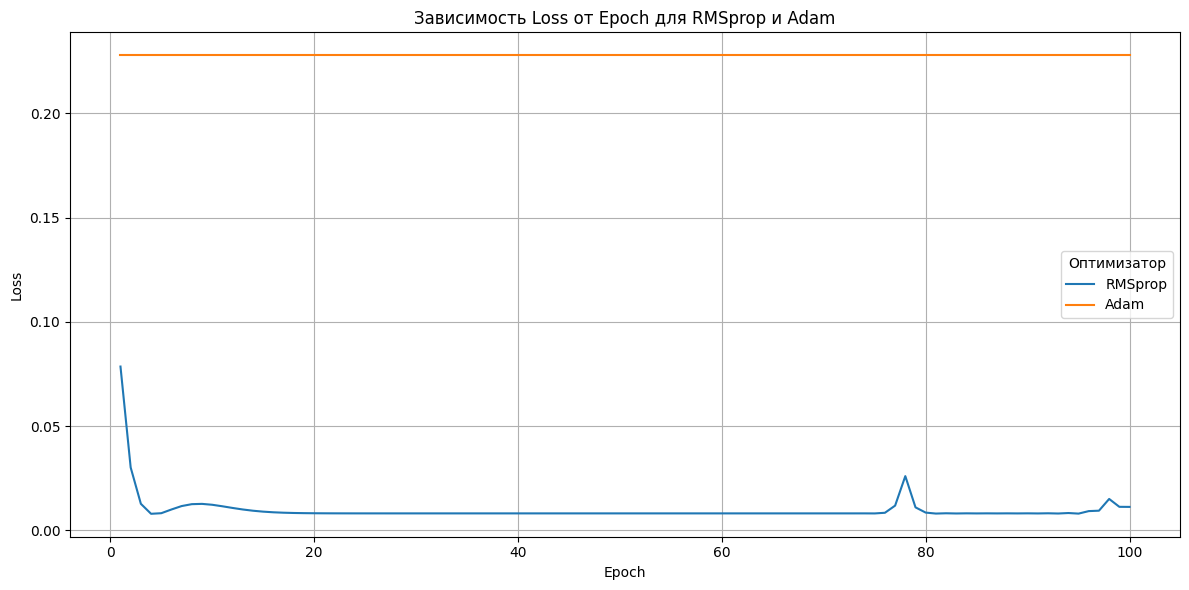

In [62]:
epochs = range(1, len(loss_rmsprop) + 1) # Создаем список эпох

loss_rmsprop_flat = [loss.item() if isinstance(loss, np.ndarray) else loss for loss in loss_rmsprop] 
loss_adam_flat = [loss.item() if isinstance(loss, np.ndarray) else loss for loss in loss_adam]       

df_rmsprop = pd.DataFrame({'Epoch': epochs, 'Loss': loss_rmsprop_flat, 'Optimizer': 'RMSprop'})
df_adam = pd.DataFrame({'Epoch': epochs, 'Loss': loss_adam_flat, 'Optimizer': 'Adam'})
df_combined = pd.concat([df_rmsprop, df_adam])

plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='Loss', hue='Optimizer', data=df_combined)

plt.title('Зависимость Loss от Epoch для RMSprop и Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Оптимизатор')
plt.grid(True)
plt.tight_layout()
plt.show()

### Задача 3.1 [1 дополнительный балл]

* Реализуй более продвинутую визуализацию работы алгоритмов отдельно для RMSprop и отдельно для Adam.
* Пример:
 * scatter plot для визуализации данных на плоскости;
 * линии предсказаний модели для каждой 10-й эпохи разными цветами;
 * можно также подписать общий loss для каждой линии.


### Задача 4 [3 балла]

1. Реализуй три вариации циклического scheduler: triangular, triangular2 и cosine. Для этого проведи небольшой ресёрч в интернете в поисках чётких формул и алгоритма работы **[2 балла]**.

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для расчёта learning rate
def cyclical_lr(iteration, eta_min, eta_max, step_size, mode='triangular'):
    """Циклический learning rate.

    Параметры:
    iteration -- номер текущей итерации
    eta_min -- минимальная скорость обучения
    eta_max -- максимальная скорость обучения
    step_size -- шаг цикла (количество итераций до изменения направления)
    mode -- режим ('triangular', 'triangular2', 'cosine')
    """
    cycle = np.floor(1+iteration/(2*step_size))
    x = abs(iteration/step_size-2*cycle+1)
    scale = 1.0

    if mode == 'triangular':
        scale = np.maximum(0, (1 - x))
    elif mode == 'triangular2':
        scale = np.maximum(0, (1 - x)) / (2**(cycle - 1))
    elif mode == 'cosine':
        scale = (1 + np.cos(np.pi * (iteration % step_size) / step_size)) / 2
    lr = eta_min + (eta_max - eta_min) * scale
    return lr


На семинаре наш loss уходил в inf значения. Вот несколько возможных причин такого поведения:

* **Слишком большой диапазон learning rate.** Если максимальное значение установлено слишком большим, обновления параметров будут слишком резкими, что приведёт к уходу в бесконечность.
* **Отсутствие нормализации данных.** Если данные ($X, y$) не нормализованы, градиенты могут становиться огромными, особенно на ранних этапах обучения.
* **Отсутствие регуляризации.** Большие learning rate могут привести к слишком большим значениям весов.

В данном задании мы нормализуем $X$ и $y$, а также уменьшим максимальное значение learning rate.


2. Добавь расчёт learning rate от scheduler и нормализацию данных **[1 балл]**.

Epoch 0: Loss = -0.0000, LR = 0.000100
Epoch 100: Loss = -0.1637, LR = 0.005050
Epoch 200: Loss = -0.7501, LR = 0.010000
Epoch 300: Loss = -0.9342, LR = 0.005050
Epoch 400: Loss = -0.9563, LR = 0.000100
Epoch 500: Loss = -0.9699, LR = 0.005050
Epoch 600: Loss = -0.9855, LR = 0.010000
Epoch 700: Loss = -0.9889, LR = 0.005050
Epoch 800: Loss = -0.9893, LR = 0.000100
Epoch 900: Loss = -0.9896, LR = 0.005050
Epoch 999: Loss = -0.9898, LR = 0.009951


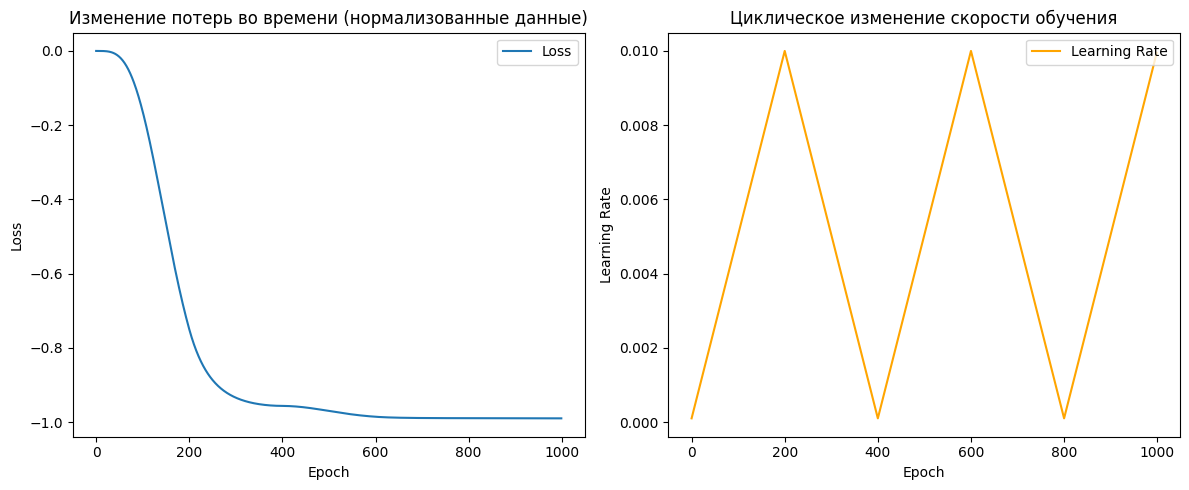

In [65]:
# Генерация данных
def generate_data(n_samples=100, noise=0.1):
    np.random.seed(42)
    X = np.random.rand(n_samples, 1) * 10
    y = 3 * X + 5 + np.random.randn(n_samples, 1) * noise
    return X, y

# Функция потерь (MSE + L2)
def compute_loss(X, y, w, b, l2_lambda=0.01):
  mse = np.mean((y-(w*X+b)**2))
  l2 = l2_lambda * w**2
  return mse + l2

# Градиентный спуск с циклическим scheduler
def train_with_scheduler_function(X, y, eta_min, eta_max, step_size, mode, n_epochs=1000):
    w = np.zeros((X.shape[1], 1))
    b = 0
    losses = []
    lrs = []

    for epoch in range(n_epochs):
        # Предсказания
        predictions = X @ w + b
        errors = predictions - y

        # Градиенты
        dw = (2 / len(y)) * X.T @ errors
        db = (2 / len(y)) * np.sum(errors)

        # Learning rate от scheduler
        lr = cyclical_lr(epoch, eta_min, eta_max, step_size=step_size, mode=mode)
        lrs.append(lr)

        # Обновление параметров
        w -= lr * dw
        b -= lr * db

        # Логирование
        loss = compute_loss(X, y, w, b).item()
        losses.append(loss)

        if epoch % 100 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch}: Loss = {loss:.4f}, LR = {lr:.6f}")

    return w, b, losses, lrs

# Нормализация данных
def normalize(X, y):
  x_mean = X.mean()
  x_std = X.std()
  
  y_mean = y.mean()
  y_std = y.std()
  
  x = (X-x_mean)/x_std
  y = (y-y_mean)/y_std
  return x, y, (x_mean, x_std, y_mean, y_std)

# Генерация данных
X, y = generate_data()
X, y, stats = normalize(X, y)

# Обучение модели с уменьшенным диапазоном learning rate
eta_min = 0.0001
eta_max = 0.01
step_size = 200
mode = 'triangular'

w, b, losses, lrs = train_with_scheduler_function(X, y, eta_min, eta_max, step_size, mode, n_epochs=1000)

# Визуализация
plt.figure(figsize=(12, 5))

# Потери
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Изменение потерь во времени (нормализованные данные)")
plt.legend()

# Learning rate
plt.subplot(1, 2, 2)
plt.plot(lrs, label="Learning Rate", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Циклическое изменение скорости обучения")
plt.legend()

plt.tight_layout()
plt.show()

